# Predicting Heart Disease

Doenças cardíacas são distúrbios que afetam componentes do coração e seus vasos sanguíneos sendo muito comum em pessoas idosas. 

Acredita-se que 90% dos casos de doenças cardiovasculares possam ser evitados com a prevenção. Por causa disso iremos analisar alguns dados de pessoas com doença cardíaca com o intuito de entender melhor seus efeitos. 

Ademais, também iremos gerar um classificador que será responsável por predizer se a pessoa possui ou não a doença a partir de informações fornecidas pela mesma.

Esse notebook é um projeto do curso da https://datascienceacademy.com.br

# 1. Leitura e conhecimento dos dados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import chi2,f_classif
from sklearn.feature_selection import RFE

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from imblearn.over_sampling import SMOTE

In [2]:
#Leitura
df_heart_disease = pd.read_csv('pacientes.csv',header=None,names=['ID','idade','sexo','pressao_sanguinea','colesterol','acucar_sangue','ecg','batimento_cardiaco','doenca'])

#Apresentacao dos dados
df_heart_disease.head()

,ID,idade,sexo,pressao_sanguinea,colesterol,acucar_sangue,ecg,batimento_cardiaco,doenca
0,1001,63,1,145,233,1,2,150,0
1,1002,67,1,160,286,0,2,108,1
2,1003,67,1,120,229,0,2,129,0
3,1004,37,1,130,250,0,0,187,0
4,1005,41,0,130,204,0,2,172,0


Segundo a documentação nós temos os seguintes atributos:

- ID: Identificador da pessoa.
- idade: Idade da pessoa.
- Sexo: Gênero sendo:
    - 0 feminino.
    - 1 masculino.
- pressao_sanguiena: Pressão sanguinea medida.
- colesterol: Colesterol medido.
- acucar_sangue: Nível de acuçar no coração sendo:
    - 0 Nível Açucar <= 120 mg/dl.
    - 1 Nível de Acuçar > 120mg/dl.
- ECG: Resultado do eletrocardiograma sendo:
    - 0 Normal.
    - 1 Alguma anomalia.
    - 2 Anomalia presente.
- batimento_cardiaco: Batimento cardíaco medido (Valor máximo).
- doenca: Indica se tem a doença ou não sendo:
    - 0 Não.
    - 1 Sim.
    
Nossas features parecem ser bem informativas, já que, sabemos de antemão que pessoas com doenças cardiovasculares tendem a ter alta pressão sanguinea, altos niveis de colesterole e etc. Provavelmente conseguiremos bons resultados a partir delas.
 
Pela variável doença, note que estamos trabalhando com um problema de classificação binário.
 
Vamos a partir de agora realizar algumas análises.

# 2. Estatísticas iniciais

Algumas estatísticas inicias para entender melhor sobre os dados.

In [3]:
#Mudando valores numericos para categoricos
df_heart_disease['ID'] = df_heart_disease['ID'].astype(str)
df_heart_disease['sexo'] = df_heart_disease['sexo'].astype(str)
df_heart_disease['acucar_sangue'] = df_heart_disease['acucar_sangue'].astype(str)
df_heart_disease['ecg'] = df_heart_disease['ecg'].astype(str)
df_heart_disease['doenca'] = df_heart_disease['doenca'].astype(str)

In [4]:
#Estatísticas iniciais
df_heart_disease.describe()

,idade,pressao_sanguinea,colesterol,batimento_cardiaco
count,303.000000,303.000000,303.000000,303.000000
mean,54.438944,131.689769,246.693069,149.607261
std,9.038662,17.599748,51.776918,22.875003
min,29.000000,94.000000,126.000000,71.000000
25%,48.000000,120.000000,211.000000,133.500000
50%,56.000000,130.000000,241.000000,153.000000
75%,61.000000,140.000000,275.000000,166.000000
max,77.000000,200.000000,564.000000,202.000000


Inicialmente podemos ver que as a maioria das pessoas são mais velhas (média de 54 anos). 

Batimento cardiaco e pressao sanguinea parecem variar de modo igual (será que possui correlação ?). 

Colesterol possui um valor altíssimo (564), possívelmente é uma pessoa bem acima do peso. Pelo que podemos ver dos percentis, não parece que temos muitos dados de pessoas com colesterol tão altos.

Ademais salientamos que:
- Não sabemos qual o tipo de pressão sanguínea foi medido (sistólica ou diastólica).
- Não sabemos qual o tipo de colesterol medido (HDL ou LDL ou ambos).
- Pressao sanguinea, colesterol e batimento cardiaco possuem valores incrivelmente altos que não são comuns em pessoas normais. Necessário realizar análises.

Fontes:
- https://www.weinmann.com.br/sua-saude/Paginas/Valores-Normais-da-Pressao-Arterial-Wenmann.aspx
- https://saude.abril.com.br/bem-estar/colesterol-as-taxas-ideais/
- https://medicoresponde.com.br/como-saber-se-os-batimentos-cardiacos-estao-normais/

In [5]:
#Número de amostras
df_heart_disease.shape[0]

303

In [6]:
#Número de pessoas únicas
len(df_heart_disease['ID'].unique())

#Note que não temos a repetição de pessoas na amostra

303

# 3. Baseline

Vamos modelar os dados na forma como eles estão para ter um baseline. Iremos utilizar três modelos:

- Regressão logísticas.
- Random Forest.
- Árvore de decisão.

Como métrica de avaliação iremos utilizar a Area Under Curve (AUC), já que, desejamos obter modelos com altos valores em recall (taxa de verdadeiros positivos) e especificidade (taxa de verdadeiros negativos). 

Como validação do poder de generalização iremos utilizar o kfold cross-validation com k=5.

In [7]:
#Separando em variaveis dependentes, independentes
X = df_heart_disease.iloc[:,1:-1]
y = df_heart_disease['doenca']

In [8]:
'''Realiza uma avaliação dos modelos nos dados.'''
def evaluate_models(X,y,oversampling=False):
    #Criando classificadores
    lr = LogisticRegression(solver='liblinear')
    dtc = DecisionTreeClassifier()
    rfc = RandomForestClassifier(n_estimators=25)

    #Dicionario de classificadores
    clfs = {'lr':lr,'dtc':dtc,'rfc':rfc}
    
    #Oversampling
    if(oversampling):
        X,y = SMOTE().fit_resample(X,y)

    #AUC para cada classificador
    for key in clfs:
        auc = cross_val_score(clfs[key],X,y,scoring='roc_auc',cv=5)
        print(key,auc,np.mean(auc))

In [9]:
#Avaliando
evaluate_models(X,y)

lr [0.71524064 0.7486631  0.84625668 0.80614973 0.73110465] 0.7694829623181196
dtc [0.64237968 0.57419786 0.62165775 0.70989305 0.59084302] 0.6277942731003607
rfc [0.64839572 0.65574866 0.76270053 0.72459893 0.65261628] 0.6888120258674294


Podemos ver que a regressão logística perfoumou melhor nos dados. Contudo, devido a grande variação nos folds vemos que há um overfitting do classificador.

Ademais, temos um baseline de 0.76 no AUC.

# 4. Análise Exploratória dos Dados

Sabendo qual é nosso baseline e tendo o objetivo de melhorar ao máximo o AUC, vamos realizar análises nos dados para verificar como podemos melhorar tais métricas.

## 4.1 Gráficos

In [10]:
#Setando estilo de gráfico igual o ggplot
plt.style.use('ggplot')

In [11]:
'''Plota um countplot.'''
def countplot(x,data,hue=None,xlabel=None,ylabel=None,dodge=True):
    #Criando figura
    fig,ax = plt.subplots(figsize=(10,7))
    sns.countplot(x=x,data=data,hue=hue,dodge=dodge,ax=ax)

    #Mudando tamanho dos xlabels/ylabels
    ax.set_xlabel(xlabel,size=15)
    ax.set_ylabel(ylabel,size=15)

    #Mudando tamanho dos xticklabels/yticklabels
    for tick_x in ax.get_xticklabels():
        tick_x.set_fontsize(13)
    for tick_y in ax.get_yticklabels():
        tick_y.set_fontsize(13)

    #Plota
    plt.show()

In [12]:
#Plot para variaveis categoricas
df_plot = df_heart_disease.select_dtypes('object').copy()

#Mudando variaveis para ficar mais facil no plot
df_plot['doenca'] = df_plot['doenca'].map({'0':'Nao','1':'Sim'})
df_plot['sexo'] = df_plot['sexo'].map({'0':'Feminino','1':'Masculino'})

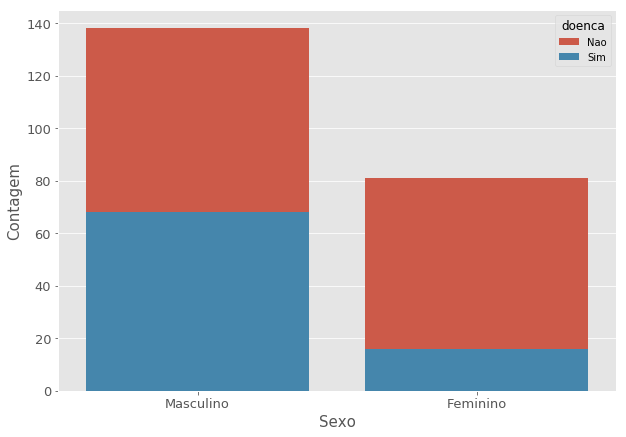

In [13]:
#Countplot para sexo
countplot('sexo',df_plot,'doenca','Sexo','Contagem',False)

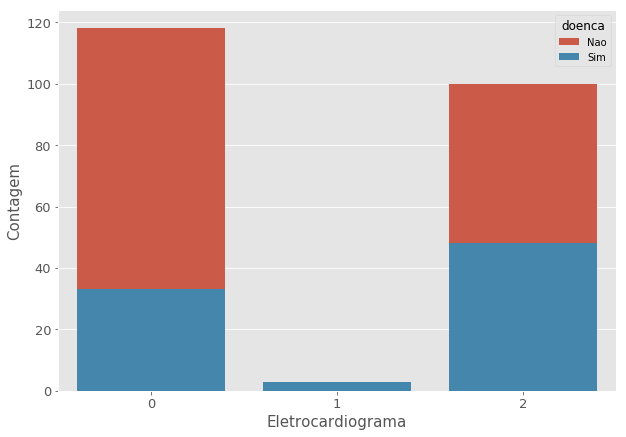

In [14]:
#Countplot para ecg
countplot('ecg',df_plot,'doenca','Eletrocardiograma','Contagem',False)

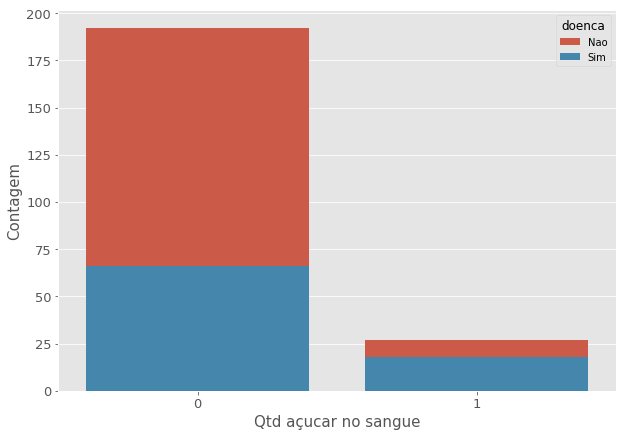

In [15]:
#Countplot para acucar_sangue
countplot('acucar_sangue',df_plot,'doenca','Qtd açucar no sangue','Contagem',False)

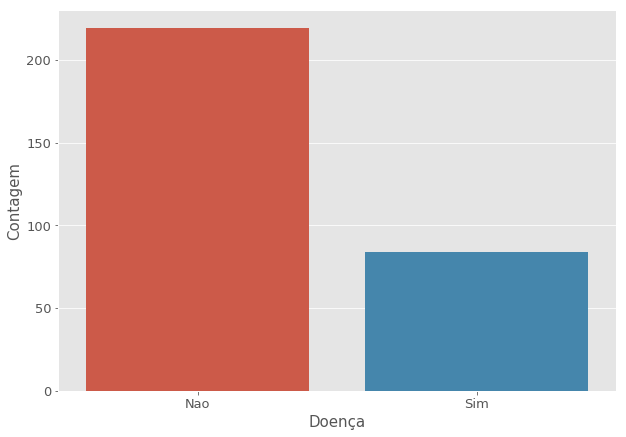

In [16]:
#Countplot para doenca
countplot(x='doenca',data=df_plot,xlabel='Doença',ylabel='Contagem')

Pelos countplot's notamos que:

- A maioria das pessoas na amostra são do sexo masculino.
- Mulheres possuem uma prevalência menor com relação a doença.
- Em suma ou as pessoas  são classificadas como nenhuma anomilia ou anomalia presente. A quantidade de pessoas com alguma anomalia é bem baixa.
- Grande maioria se encontra com níveis de açucar menores que 120 mg/dl.
- A maior parte das pessoas não possui doença cardiovasculares.
- Notamos que de modo geral temos um grande desbalancemanto nos atributos categóricos assim como na variável target.

Observação:
- Devido ao desbalanceamento da variável acuçar no sangue, sua utilização pode causar um viés.
- Como temos poucas pessoas com ecg igual a 1 devemos considerar uma recategorização.

In [17]:
#Plot para variaveis numericas
df_plot = df_heart_disease.select_dtypes('int').copy()
df_plot['doenca'] = df_heart_disease['doenca'].map({'0':'Nao','1':'Sim'})

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


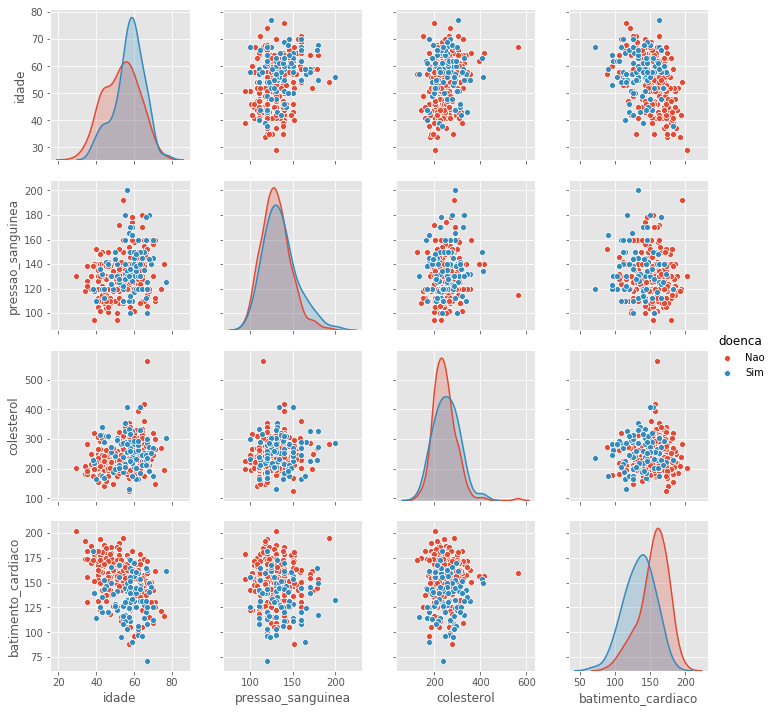

In [18]:
#Pairplot
sns.pairplot(data=df_plot,hue='doenca')
plt.show()

De modo geral temos uma grande sobreposição das classes.

As features numéricas aparentam seguir uma normal.

Temos um valor bem alto para colesterol (conforme constatado antes), possívelmente um outlier.

In [19]:
'''Plot varios boxplot's.'''
def boxplot(df,x,cols):

    #Criando figura
    fig = plt.figure(figsize=(15,7))
    
    #Ajustando parametros
    fig.subplots_adjust(wspace=0.6,hspace=0.5)
    
    #Tres boxplot's por linha
    ncol= 3

    #Quantidade de linhas
    nrow = (len(cols)/ncol)+1

    #Subplots
    for index,c in enumerate(cols):
        ax = fig.add_subplot(nrow,ncol,index+1)
        sns.boxplot(data=df,x=x,y=c,ax=ax)
    plt.show()

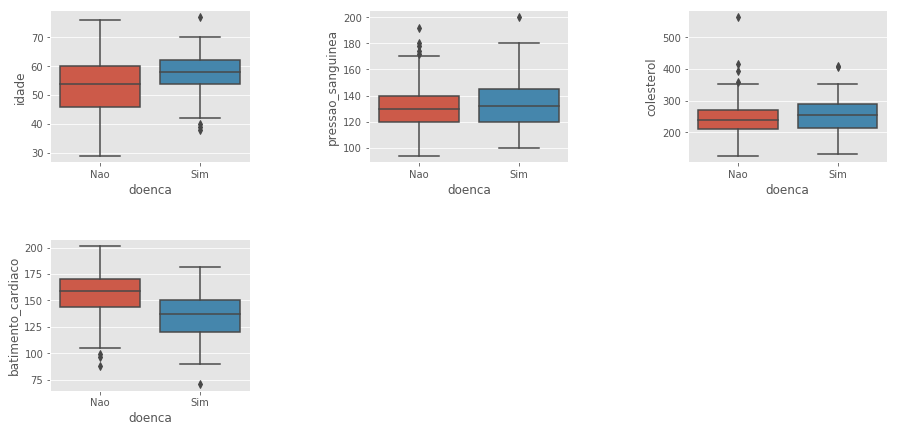

In [20]:
#Boxplot
boxplot(df_plot,'doenca',df_plot.columns[:-1])

Aparentemente apenas em batimento cardiaco que temos uma diferença entre os grupos.

In [21]:
#Mapenado doenca como variavel numerica
df_plot['doenca'] = df_plot['doenca'].map({'Nao':0,'Sim':1})

#Correlacao
corr_matrix = df_plot.corr().abs()

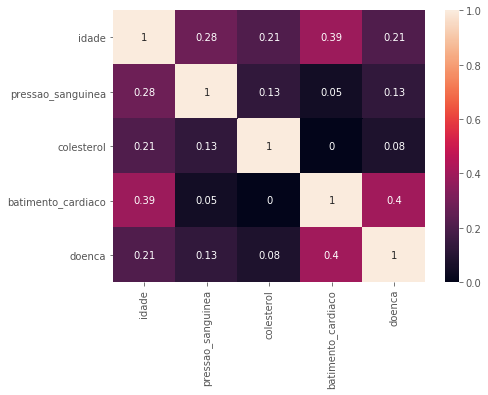

In [22]:
#Heatmap
fig,ax = plt.subplots(figsize=(7,5))
sns.heatmap(round(corr_matrix,2),ax=ax,vmin=0,vmax=1,annot=True)
plt.show()

Conforme visto no boxplot e pelas correlações com o target, batimento cardiaco aparenta ser a variavel mais promissora.

Ademais não temos grandes correlações com exceção de batimento cardíaco e idade.

Observação: Utilizamos os valores absolutos para ficar mais fácil a visualização. Note que a correlação entre batimento cardíaco e idade é na verdade negativa.

## 4.2 Testes estatísticos univariados

Vamos realizar testes qui-quadrado e anova nas variáveis.

Lembrando que o teste qui-quadrado testa a hipótese nula de independência entre as variáveis e o target, enquanto que o ANOVA testa a hipótese nula de que as médias são iguais entre os grupos.

In [23]:
#Variaveis independentes categoricas
X_cat = df_heart_disease.select_dtypes('object')
X_cat = X_cat.drop(columns=['ID','doenca'])

#Variaveis independentes categoricas
X_num = df_heart_disease.select_dtypes('int')

#Variavel dependente
y = df_heart_disease['doenca']

In [24]:
#Chi-squared
_,pvalue = chi2(X_cat,y)
pvalue = dict(zip(X_cat.columns,np.round(pvalue,4)))
pvalue = pd.DataFrame.from_dict(pvalue,orient='index',columns=['pvalue'])
pvalue.sort_values(by='pvalue',inplace=True)
pvalue

,pvalue
ecg,0.0412
acucar_sangue,0.0658
sexo,0.0900


In [25]:
#ANOVA
_,pvalue = f_classif(X_num,y)
pvalue = dict(zip(X_num.columns,np.round(pvalue,4)))
pvalue = pd.DataFrame.from_dict(pvalue,orient='index',columns=['pvalue'])
pvalue.sort_values(by='pvalue',inplace=True)
pvalue

,pvalue
batimento_cardiaco,0.0000
idade,0.0003
pressao_sanguinea,0.0218
colesterol,0.1879


Setando num nível alpha = 5% de signifância temos pelos testes que as seguintes variáveis são importantes:

- ecg
- batimento_cardiaco
- idade
- pressao_sanguinea

Tais variáveis fazem sentido em terem uma contribuição com doenças cardíacas. Ademais, as outras features não possuem valores muito altos (p-valor). Justamente por causa disso não iremos simplesmente descartá-las mas já temos uma boa ideia de qual possívelmente serão as melhores.

# 5. Recategorização

Vamos realizar uma recategorização nas variáveis.

## 5.1 Feature ecg

In [26]:
#Tabela de frequencias
df_heart_disease.groupby(['ecg','doenca']).size()

ecg  doenca
0    0         118
     1          33
1    0           1
     1           3
2    0         100
     1          48
dtype: int64

Como ecg = 1 só aparece em 4 amostras iremos mapeá-las como anomalia presente. Assim, iremos colocar as categorias 1 e 2 como uma só.

In [27]:
#Mapeando
df_heart_disease['ecg'] = df_heart_disease['ecg'].map({'0':'0','1':'1','2':'1'})

## 5.2 Feature idade

In [28]:
def idade_map(x):
    if(x<=50):
        return 1
    elif(x<=60):
        return 2
    else:
        return 3

#Categorizando em 3 valores
df_heart_disease['idade'] = df_heart_disease['idade'].map(idade_map)

Consideramos 3 categorias pois esse valor consegue manter o balanceamento entre as classes para cada uma.

# 6. Modelagem

## 6.1 Oversampling

Pelas análises anteriores nós sabemos que o dataset está desbalanceado. Desse modo, vamos ver o que ocorre com o AUC quando realizamos um oversampling com a técnica SMOTE.

In [29]:
#Excluindo essa coluna por nao ser necessario
del df_heart_disease['ID']

#Separando dataset
X = df_heart_disease.iloc[:,:-1]
y = df_heart_disease['doenca']

In [30]:
#Avaliação com oversampling
evaluate_models(X,y,oversampling=True)

lr [0.75619835 0.76859504 0.74380165 0.8713843  0.77393186] 0.7827822387799526
dtc [0.57954545 0.63636364 0.65909091 0.77272727 0.68604651] 0.6667547568710359
rfc [0.77143595 0.75       0.91477273 0.9723657  0.94672796] 0.8710604682450643


Note que os valores estão bem mais altos com o oversampling. Sabemos que nem sempre é ideal realizar o oversampling dado que estamos inputando dados sintéticos. Contudo, iremos manter essa ténica dada a melhora que obtemos no AUC.

Vemos que em alguns casos a Random Forest performou muito melhor do que antes. Ainda assim nós temos indicação de overfitting nos dados.

Nosso baseline agora é de 0.86.

## 6.2 Feature Selection - RFE

Vamos verificar quais variáveis auxilam mais nos modelos com a ajuda do Recursive Feature Elimination.

In [31]:
#Variaveis categoricas independentes
X = df_heart_disease.iloc[:,:-1]

#Target
y = df_heart_disease['doenca']

In [32]:
#Estimador
rfc = RandomForestClassifier(n_estimators=25)

In [33]:
for k in range(1,X.shape[1]):
    
    #Criando RFE
    rfe = RFE(rfc,k).fit(X,y)

    #Treinando
    selected_cols = X.columns[rfe.get_support()]

    #Avaliando o modelo com as colunas selecionadas
    print(selected_cols.values)
    evaluate_models(X.loc[:,selected_cols],y,oversampling=True)
    print('\n')

['colesterol']
lr [0.58961777 0.51730372 0.51885331 0.48372934 0.5970795 ] 0.5413167269330306
dtc [0.6206095  0.61389463 0.6322314  0.60072314 0.73823688] 0.6411391124977092
rfc [0.65315083 0.62577479 0.61854339 0.61983471 0.76608978] 0.6566786994533566


['colesterol' 'batimento_cardiaco']
lr [0.77272727 0.73450413 0.71384298 0.83006198 0.68631693] 0.7474906583411179
dtc [0.75       0.65909091 0.79545455 0.81818182 0.6744186 ] 0.739429175475687
rfc [0.81947314 0.7856405  0.91167355 0.91528926 0.81936182] 0.8502876526958956


['pressao_sanguinea' 'colesterol' 'batimento_cardiaco']
lr [0.76549587 0.77376033 0.80733471 0.80578512 0.74580855] 0.7796369156434795
dtc [0.69318182 0.64772727 0.76136364 0.72727273 0.73255814] 0.7124207188160676
rfc [0.83910124 0.72649793 0.91038223 0.87654959 0.84991888] 0.8404899733606281


['idade' 'pressao_sanguinea' 'colesterol' 'batimento_cardiaco']
lr [0.76188017 0.79028926 0.77272727 0.79597107 0.71984857] 0.7681432670775805
dtc [0.65909091 0.64772727 0

Note que temos resultados bem altos considerandos todas as variáveis. Contudo, também temos uma grande variação em cada fold.

A melhor combinação segundo o RFE acaba sendo:
- pressao_sanguinea
- colesterol
- batimento_cardiaco

Pelas análises anteriores nós já tínhamos visto que tais features apresentam ser interessantes.

## 6.3 Resultado final

Iremos realizar a modelagem final no Random Forest realizando um prunning nos seus parâmetros considerando as features da etapa anterior.

In [34]:
#Colunas para modelagem
cols = ['pressao_sanguinea','colesterol','batimento_cardiaco','doenca']
df_heart_disease = df_heart_disease.loc[:,cols]

In [35]:
#Divindo dataset
X = df_heart_disease.iloc[:,:-1]
y = df_heart_disease['doenca']

Vamos inicialmente realizar uma busca randomica na tentativa de encontrar um minimo local.

In [36]:
#Criando estimador
rfc = RandomForestClassifier()

#Parametros para o RandomSearch
param = {
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_features': [1,2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [10,20,30,40,50]
}

#Criando busca randomica de parametros
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = param, n_iter = 100, cv = 5,random_state=42,scoring='roc_auc')

#Fit
rf_random.fit(X,y)

/home/sugi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_features': [1, 2, 3], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [10, 20, 30, 40, 50]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=0)

In [37]:
#Melhores parametros
rf_random.best_params_

{'n_estimators': 10,
 'min_samples_split': 12,
 'min_samples_leaf': 3,
 'max_features': 2,
 'max_depth': 60}

Vamos agora realizar uma busca exaustiva em locais perto desses parâmetros.

In [38]:
#Parametros para o RandomSearch
param = {
    'max_depth': [40,50,60],
    'max_features': [2],
    'min_samples_leaf': [3,5,7],
    'min_samples_split': [10, 12,14],
    'n_estimators': [35,40,45,50,55]
}

#Criando busca randomica de parametros
grid_search = GridSearchCV(estimator = rfc, param_grid = param, cv = 5,scoring='roc_auc')

#Fit
grid_search.fit(X,y)

/home/sugi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [40, 50, 60], 'max_features': [2], 'min_samples_leaf': [3, 5, 7], 'min_samples_split': [10, 12, 14], 'n_estimators': [35, 40, 45, 50, 55]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [39]:
#Melhores parametros
grid_search.best_params_

{'max_depth': 60,
 'max_features': 2,
 'min_samples_leaf': 7,
 'min_samples_split': 12,
 'n_estimators': 45}

In [40]:
#Criando classificador
rfc = RandomForestClassifier(max_depth=40,max_features=2,min_samples_leaf=3,min_samples_split=14,n_estimators=50)

#Dividindo dataset
X = df_heart_disease.iloc[:,:-1]
cols = X.columns
y = df_heart_disease['doenca']

#Oversampling
X,y = SMOTE().fit_resample(X,y)

#AUC para cada classificador
auc = cross_val_score(rfc,X,y,scoring='roc_auc',cv=5)
print(auc,np.mean(auc),np.std(auc))

[0.81017562 0.7892562  0.85847107 0.84349174 0.77771769] 0.8158224626668872 0.030900226663358354


In [41]:
#Fit do classificador
rfc = rfc.fit(X,y)

#Feature mais importante
cols[np.argmax(rfc.feature_importances_)]

'batimento_cardiaco'

Ao final de todas as etapas foi possível obter um classificador com AUC próximo a 82% e aparentemente sem overfitting.

Também notamos que a feature mais imporante para as decisões é o batimento cardíaco.

# 7. Conclusão

O melhor classificador dentre todos testados é o Random Forest com os seguintes parâmetros:

 - max_depth: 40
 - max_features: 2
 - min_samples_leaf: 3
 - min_samples_split: 14
 - n_estimators: 50
 
O mesmo conseguiu um AUC de aproximadamente 82% nos dados. Salietamos que esse valor só foi possível porque utilizamos métodos de reamostragem (oversampling com SMOTE). Assim, para melhores resultados certamente uma maior quantidade de dados iria nos auxiliar a gerar um melhor classificador.

Vimos que a feature mais interessante para indentificar pessoas com doença cardíaca ou não é o batimento cardíaco. Fato que foi identificado tanto no teste ANOVA como no Random Forest.

Por fim, salientamos que não realizamos a exclusão de pessoas que com níveis de colesterol altos ( < 400) por não termos muitas informações se tais medidas são corretas ou não. O que sabemos é que não é natural tais valores dado que uma pessoa normal possui níves muito mais baixos.